# Setup

In [1]:
import itertools
import pickle
from pathlib import Path

import gc
import torch as t
from torch import nn, Tensor
from torch.nn import functional as F
import einops
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas

from typing import Tuple, List, Optional, Dict
from jaxtyping import Float, Int
from functools import partial

import transformer_lens as tl
import datasets
from transformers import AutoTokenizer, GPT2LMHeadModel

from IPython.display import display, HTML, clear_output

device = t.device("cuda" if t.cuda.is_available() else "cpu")

DO_ATTN_SAE = False


# Load models and autoencoders
Joseph's SAEs on residual stream: https://huggingface.co/jbloom/GPT2-Small-SAEs
Github for Joseph's: https://github.com/jbloomAus/mats_sae_training
(post here: https://www.lesswrong.com/posts/f9EgfLSurAiqRJySD/open-source-sparse-autoencoders-for-all-residual-stream)

Colab for loading Kissane attention head autoencoders: https://colab.research.google.com/drive/1hZVEM6drJNsopLRd7hKajp_2v6mm_p70?usp=sharing (post here: https://www.lesswrong.com/posts/FSTRedtjuHa4Gfdbr/attention-saes-scale-to-gpt-2-small)


## Load Residual Stream Autoencoders

In [2]:
#Get joseph's autoencoders
if not Path('GPT2-Small-SAEs').exists():
    #requires git-lfs!
    !git clone https://huggingface.co/jbloom/GPT2-Small-SAEs
    !git clone https://github.com/jbloomAus/mats_sae_training.git
    !pip install -rq mats_sae_training/requirements.txt
    !mv mats_sae_training/* .

In [3]:
# Load residual stream autoencoders
from sae_training.utils import LMSparseAutoencoderSessionloader
from sae_training.sparse_autoencoder import SparseAutoencoder as ResidualSparseAutoencoder

sparse_encoders_residual = []

# load everything once
path = f"./GPT2-Small-SAEs/final_sparse_autoencoder_gpt2-small_blocks.{0}.hook_resid_pre_24576.pt"
model, sparse_autoencoder, activations_loader = LMSparseAutoencoderSessionloader.load_session_from_pretrained(
    path
)
sparse_autoencoder.cfg.use_ghost_grads = False
sparse_encoders_residual.append(sparse_autoencoder)

for i in tqdm(range(1, 12)):
    path = f"./GPT2-Small-SAEs/final_sparse_autoencoder_gpt2-small_blocks.{i}.hook_resid_pre_24576.pt"
    sparse_autoencoder = ResidualSparseAutoencoder.load_from_pretrained(path)
    sparse_autoencoder.cfg.use_ghost_grads = False
    sparse_encoders_residual.append(sparse_autoencoder)
clear_output()

In [4]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
hf_model = GPT2LMHeadModel.from_pretrained("gpt2")
inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
outputs = hf_model(**inputs)

## Load Attention autoencoders

### Architecture

In [5]:
if DO_ATTN_SAE and not Path('attn-saes-gpt2-small-all-layers').exists():
    !git clone https://huggingface.co/ckkissane/attn-saes-gpt2-small-all-layers

In [6]:
DTYPES = {"fp32": t.float32, "fp16": t.float16, "bf16": t.bfloat16}
class AutoEncoder(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        d_hidden = cfg["dict_size"]
        l1_coeff = cfg["l1_coeff"]
        dtype = DTYPES[cfg["enc_dtype"]]
        t.manual_seed(cfg["seed"])
        self.W_enc = nn.Parameter(t.nn.init.kaiming_uniform_(t.empty(cfg["act_size"], d_hidden, dtype=dtype)))
        self.W_dec = nn.Parameter(t.nn.init.kaiming_uniform_(t.empty(d_hidden, cfg["act_size"], dtype=dtype)))
        self.b_enc = nn.Parameter(t.zeros(d_hidden, dtype=dtype))
        self.b_dec = nn.Parameter(t.zeros(cfg["act_size"], dtype=dtype))

        self.W_dec.data[:] = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)

        self.d_hidden = d_hidden
        self.l1_coeff = l1_coeff
        self.dtype = dtype
        self.device = cfg["device"]


        self.version = 0
        self.to(cfg["device"])

    def forward(self, x, per_token=False):
        x_cent = x - self.b_dec
        acts = F.relu(x_cent @ self.W_enc + self.b_enc) # [batch_size, d_hidden]
        x_reconstruct = acts @ self.W_dec + self.b_dec # [batch_size, act_size]
        if per_token:
            l2_loss = (x_reconstruct.float() - x.float()).pow(2).sum(-1) # [batch_size]
            l1_loss = self.l1_coeff * (acts.float().abs().sum(dim=-1)) # [batch_size]
            loss = l2_loss + l1_loss # [batch_size]
        else:
            l2_loss = (x_reconstruct.float() - x.float()).pow(2).sum(-1).mean(0) # []
            l1_loss = self.l1_coeff * (acts.float().abs().sum(dim=-1).mean(dim=0)) # []
            loss = l2_loss + l1_loss # []
        return loss, x_reconstruct, acts, l2_loss, l1_loss


    @classmethod
    def load_from_hf(cls, version, hf_repo="ckkissane/tinystories-1M-SAES"):
        """
        Loads the saved autoencoder from HuggingFace.
        """

        cfg = tl.utils.download_file_from_hf(hf_repo, f"{version}_cfg.json")
        self = cls(cfg=cfg)
        self.load_state_dict(tl.utils.download_file_from_hf(hf_repo, f"{version}.pt", force_is_torch=True))
        return self

In [7]:
if DO_ATTN_SAE:
    attn_sae_path = Path('attn-saes-gpt2-small-all-layers')
    files = sorted(attn_sae_path.glob('*.pt'), key= lambda x: int(str(x).split('_L')[-1].split('_Hcat')[0]))
    sparse_encoders_attn = []
    for f in tqdm(files):
        run = str(f).split('/')[-1].split('.pt')[0]
        #TODO load these from already downloaded files instead of HF.
        encoder = AutoEncoder.load_from_hf(run, hf_repo="ckkissane/attn-saes-gpt2-small-all-layers")
        sparse_encoders_attn.append(encoder)


# Testing functions

In [8]:
def test_next_token(prompts: list, answers: list, comparison_tokens: list = None,
                    sparse_encoder = None, act_name: str = None,
                    model_call=model.run_with_cache, tot=100, batch_size=10,
                    activations_length=128):
    """
    TODO: make this docstring not suck.
    Runs a bunch of prompts through a model where the goal is for the model to predict the next token
    and the answer is known.

    A sparse autoencoder can optionally be provided, in which case the autoencoder's performance is
    tracked on the questions being studied.

    Inputs:
    -------
    prompts: list
        A list object of strings which will be tokenized.
    answers: list
        a list of integers, containing the token value of the right answer.
    comparison_tokens: list, optional
        A list of integer lists (for each prompt, ther is a list of other tokens to compare model performance for.
    sparse_encoder: Autoencoder, optional
        An autoencoder object *** check that autoencoder returns things in the same order as your implementation.
    act_name: str, optional
        The name of the activation the autoencoder reconstructs.
    model_call: Callable, optional
        The function call to be used for a forward pass; should return a cache and logits.
    tot: int, optional
        Total number of prompts to do
    batch_size: int, optional
        Number of prompts to do in each batch
    activations_length: int, optional
        Number of autoencoder feature activations (from end of prompt backwards) to save and output

    Returns:
    --------
    info: dict, with the following items:
        top10_logit_vals:
        top10_logit_toks: 
        logit_norm: 
        top_diff:
        correct:
        logit_answer:
        logit_comparisons:
        sae_l0:
        sae_l1:
        activation_l2:
        sae_mse:
        num_tokens:
        feat_activations:
    """
    correct = 0

    info = {'top10_logit_vals': [], 'top10_logit_toks': [], 'logit_norm': [],
            'top_diff': [], 'correct': [], 'logit_answer': [], 'logit_comparisons': [],
            'sae_l0': [], 'sae_l1': [], 'activation_l2': [], 'sae_mse': [],
            'num_tokens': [], 'feat_activations' : []}
    #store top 10 logit predictions for each answer.
    # Also store logit_norm -> normalization factor to turn exp(logit) into a prob
    # Store correct (True/False)
    # Store logit answer (logit value of the correct answer token)
    # Also store top_diff, which:
    #   - if answer is correct, this is logit(correct) - logit(second highest)
    #   - if answer is incorrect, this is logit(highest) - logit(correct)
    for i in tqdm(range(tot // batch_size)):
        t.cuda.empty_cache()
        gc.collect()
        batch = model.to_tokens(prompts[batch_size*i:batch_size*(i+1)])
        last_indices = t.Tensor([model.to_tokens(prompts[batch_size*i + j]).shape[1]-1 for j in range(batch_size)]).to(int)
        output, cache = model_call(batch)


        last = output.argmax(dim=-1)
        preds = t.Tensor([last[i,j].item() for i, j in enumerate(last_indices)]).to(int)
        ans = t.Tensor([ans for ans in answers[batch_size*i:batch_size*(i+1)]]).to(int)
        correct_answer = preds == ans
        correct += (correct_answer).sum().item()
        # print(preds, ans, "'{:s}'".format(model.to_string(preds)), "'{:s}'".format(model.to_string(ans)))

        if comparison_tokens is not None:
            comparisons = comparison_tokens[batch_size*i:batch_size*(i+1)]

        for i, j in enumerate(last_indices):
            info['num_tokens'].append(j+1)

            top10 = t.topk(output[i,j], k=10, dim=-1)
            info['top10_logit_vals'].append(top10.values.detach().cpu().numpy())
            info['top10_logit_toks'].append(top10.indices.detach().cpu().numpy())
            info['logit_norm'].append(t.log(t.sum(t.exp(output[i,j]))).item())
            if correct_answer[i]:
                info['top_diff'].append((top10.values[0] - top10.values[1]).item())
            else:
                info['top_diff'].append((output[i,j,ans[i]] - top10.values[0]).item())
            info['correct'].append(correct_answer[i].item())
            info['logit_answer'].append(output[i,j,ans[i]].item())
            if comparison_tokens is not None:
                info['logit_comparisons'].append(t.gather(output[i,j], dim=-1, index=comparisons[i].to(device)).detach().cpu().numpy())

            #store SAE information
            #TODO: get act_name automatically.
            if sparse_encoder is not None:
                #note that the loss definitions are slightly different between residual and attn implementations; don't compare directly.
                if type(sparse_encoder) == AutoEncoder:
                    activation = cache[act_name][i,:j,:]
                    if sparse_encoder.cfg["concat_heads"]:
                        activation = einops.rearrange(
                                activation, "seq n_heads d_head -> seq (n_heads d_head)"
                        )
                    loss, sae_out, feature_acts, mse_loss, l1_loss = sparse_encoder(activation)
                    if not sparse_encoder.cfg["concat_heads"]:
                        feature_acts = einops.rearrange(
                                feature_acts, "seq n_heads d_head -> seq (n_heads d_head)"
                        )
                elif sparse_encoder is not None:
                    activation = cache[act_name][i,:j,:]
                    sae_out, feature_acts, loss, mse_loss, l1_loss, mse_loss_ghost_resid = sparse_encoder(activation)
                l0 = (feature_acts > 0).float().sum(dim=-1).mean()
                info['sae_l0'].append(l0.item())
                info['sae_l1'].append(l1_loss.item())
                info['sae_mse'].append(mse_loss.item())
                info['activation_l2'].append(t.norm(activation, dim=-1).mean().item())
                info['feat_activations'].append(feature_acts[-activations_length:].detach().cpu().numpy())
                # print(info['feat_activations'][-1].shape)

    print(f'acc: {100*correct/tot:.2f}%')
    for k in info.keys():
        info[k] = np.array(info[k])
    return info


# Test performance vs context length

We want to see how the model performs at different contexts lengths than the one it was trained on


In [9]:
from sae_training.activations_store import ActivationsStore
from sae_training.config import LanguageModelSAERunnerConfig
test_prompts = 100
context_sizes = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
measure_window = 128
batch_size = 2
tok_per_batch = 1024*batch_size

In [25]:
act_loader = activations_loader
# act_loader = activations_loader
act_store_cfg = act_loader.cfg.__dict__
for k in ['feature_sampling_method', 'resample_batches', 'feature_reinit_scale', 'dead_feature_estimation_method', 'd_sae', 'tokens_per_buffer', 'run_name']:
    try:
        del act_store_cfg[k]
    except:
        pass

act_stores = []
for context_size in tqdm(context_sizes):
    act_store_cfg['context_size'] = context_size
    act_store_cfg['store_batch_size'] = tok_per_batch // context_size
    cfg = LanguageModelSAERunnerConfig(**act_store_cfg)
    print(cfg)
    
    gc.collect()
    t.cuda.empty_cache()
    act_store = ActivationsStore(cfg, model)
    act_stores.append(act_store)
clear_output()

In [19]:

full_l0s = np.zeros((test_prompts, len(context_sizes), len(sparse_encoders_residual)))
full_l1s = np.zeros_like(full_l0s)
full_mses = np.zeros((test_prompts, len(context_sizes), len(sparse_encoders_residual)))
full_act_l2 = np.zeros((test_prompts, len(context_sizes), len(sparse_encoders_residual)))
for i in tqdm(range(int(np.ceil(test_prompts / act_store_cfg['store_batch_size'])))):
    l0s = [[] for i in range(len(sparse_encoders_residual))]
    with t.no_grad():
        
        gc.collect()
        t.cuda.empty_cache()
        # full_batch_tokens = act_store.get_batch_tokens() old version
        for j, context_size in enumerate(context_sizes):
            batch_tokens = act_stores[j].get_batch_tokens()
            ## batch_toks = []
            ## for b in range(tok_per_batch // (context_size*batch_size)):
            ##     batch_toks.append(act_store.get_batch_tokens()[:,:context_size])
            ## batch_tokens = t.concatenate(batch_toks, axis=0).to(device)
            # print(batch_tokens.shape)
            # batch_tokens = full_batch_tokens[:,-context_size:] old version
            _, cache = model.run_with_cache(batch_tokens, prepend_bos=True)
            for k, autoencoder in enumerate(sparse_encoders_residual):

                activations = cache[autoencoder.cfg.hook_point][:,-measure_window:,:]

                sae_out, feature_acts, loss, mse_loss, l1_loss, _ = autoencoder(
                    activations
                )
                l1 = t.abs(feature_acts).sum(-1).mean(-1).detach()
                l0 = (feature_acts > 0).float().sum(-1).mean(-1).detach()
                se = ((activations - sae_out)**2).sum(-1).mean(-1).detach()
                square_acts = t.sqrt((activations**2).sum(-1)).mean(-1).detach()
                for z in range(act_store_cfg['store_batch_size']):
                    idx = i*act_store_cfg['store_batch_size'] + z
                    full_l1s[idx,j,k] = l1[z]
                    full_l0s[idx,j,k] = l0[z]
                    full_mses[idx,j,k] = se[z]
                    full_act_l2[idx,j,k] = square_acts[z]
                
            del cache
clear_output()

# full_l0s = np.array(full_l0s) #test_prompts x n_sae x context_size
print(full_l0s.shape)
print(full_l0s.mean(axis=0))
print(full_mses.mean(axis=0))
print(full_act_l2.mean(axis=0))

(100, 11, 12)
[[6.00000000e+00 5.00000000e+00 9.00000000e+00 1.20000000e+01
  1.10000000e+01 9.00000000e+00 1.20000000e+01 1.00000000e+01
  8.00000000e+00 1.20000000e+01 1.00000000e+01 9.00000000e+00]
 [9.61000000e+00 8.44500000e+00 1.11450000e+01 1.40800000e+01
  1.40150000e+01 1.36200000e+01 1.64350000e+01 1.61550000e+01
  1.63000000e+01 1.84350000e+01 1.40950000e+01 1.64500000e+01]
 [1.18375000e+01 1.14225000e+01 1.43575000e+01 2.01850000e+01
  2.34950000e+01 2.73400000e+01 3.05575000e+01 3.26925000e+01
  3.39675000e+01 3.60325000e+01 2.67500000e+01 3.03525000e+01]
 [1.40637500e+01 1.34150000e+01 1.72837500e+01 2.44325000e+01
  2.88862500e+01 3.53712500e+01 3.96850000e+01 4.37550000e+01
  4.65700000e+01 4.97875000e+01 3.66662500e+01 4.14837500e+01]
 [1.71687500e+01 1.54700000e+01 1.96731250e+01 2.66000000e+01
  3.22781250e+01 4.02187500e+01 4.52193750e+01 5.04518750e+01
  5.48712500e+01 5.78581250e+01 4.32600000e+01 4.67706250e+01]
 [1.58450000e+01 1.56200000e+01 1.98721875e+01 2.66

In [26]:
full_baseline_losses = np.zeros((test_prompts, len(context_sizes)))
full_sae_losses = np.zeros((test_prompts, len(context_sizes), len(sparse_encoders_residual)))
for i in tqdm(range(int(np.ceil(test_prompts / act_store_cfg['store_batch_size'])))):
    with t.no_grad():
        # full_batch_tokens = act_store.get_batch_tokens() old version
        for j, context_size in enumerate(context_sizes):
            batch_tokens = act_stores[j].get_batch_tokens()
            # batch_toks = []
            # for b in range(tok_per_batch // (context_size*batch_size)):
            #     batch_toks.append(act_store.get_batch_tokens()[:,-context_size:])
            # batch_tokens = t.concatenate(batch_toks, axis=0).to(device)
            # batch_tokens = full_batch_tokens[:,-context_size:] old version
            logits = model(batch_tokens, prepend_bos=True)
            orig_loss = tl.utils.lm_cross_entropy_loss(logits[:,-measure_window:,:], batch_tokens[:,-measure_window:], per_token=True)
            _, cache = model.run_with_cache(batch_tokens, prepend_bos=True)
            for k, autoencoder in enumerate(sparse_encoders_residual):
                gc.collect()
                t.cuda.empty_cache()

                def reconstr_hook(activation, hook):
                    sae_out, feature_acts, loss, mse_loss, l1_loss, _ = autoencoder(activation)
                    return sae_out

                def zero_abl_hook(activation, hook):
                    return t.zeros_like(activation)

                reconst_logits = model.run_with_hooks(
                    batch_tokens,
                    fwd_hooks=[
                        (autoencoder.cfg.hook_point, reconstr_hook)
                        ],
                    prepend_bos=True
                )
                reconst_loss = tl.utils.lm_cross_entropy_loss(reconst_logits[:,-measure_window:,:], batch_tokens[:,-measure_window:], per_token=True)
                
                for z in range(act_store_cfg['store_batch_size']):
                    idx = i*act_store_cfg['store_batch_size'] + z
                    if k == 0:
                        full_baseline_losses[idx,j] = orig_loss[z].mean().item()
                    full_sae_losses[idx,j,k] = reconst_loss[z].mean().item()
clear_output()

print(full_baseline_losses.mean(axis=0))
print(full_sae_losses.mean(axis=0))

[       nan 9.28542501 6.26578915 5.5369763  4.60769644 3.87214783
 3.64854437 3.45970162 3.09207114 3.01623801 3.07961767]
[[        nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan]
 [ 9.28985656  9.27936617  9.2847752   9.32181604  9.33050923  9.24504985
   9.31202689  9.25248826  9.29304055  9.16072589  9.67399737  9.29962719]
 [ 6.27643646  6.29125663  6.27809743  6.33217844  6.3327575   6.34417454
   6.31979113  6.29665206  6.31666868  6.29294397  6.48949033  6.35616484]
 [ 5.57412658  5.54325697  5.56509119  5.58746939  5.58529311  5.58253598
   5.59763705  5.60812333  5.60814951  5.59322552  5.70278757  5.67719343]
 [ 4.64214115  4.62388051  4.66160286  4.6857693   4.69292913  4.73985527
   4.7169418   4.73619839  4.74377402  4.75070673  4.82066425  4.83113847]
 [ 3.88272336  3.88621808  3.95234608  4.02289226  4.00158809  4.00479592
   3.99724258  3.99842661  4.00399547  4.02678324  4.1190

In [27]:
block_mses = np.zeros((test_prompts, len(sparse_encoders_residual), len(sparse_encoders_residual)))
block_l0s = np.zeros_like(block_mses)
block_act_l2s = np.zeros_like(block_mses)
model.reset_hooks()
for i in tqdm(range(int(np.ceil(test_prompts / act_store_cfg['store_batch_size'])))):
    with t.no_grad():
        for j, context_size in enumerate(context_sizes):
            if context_size != 128: continue #only do 128
            batch_tokens = act_stores[j].get_batch_tokens()
            for k, first_autoencoder in enumerate(sparse_encoders_residual):
                gc.collect()
                t.cuda.empty_cache()
                
                #Get cache while replacing activations at layer k.
                def reconstr_hook(activation, hook):
                    sae_out, feature_acts, loss, mse_loss, l1_loss, _ = first_autoencoder(activation)
                    return sae_out
                    
                model.add_hook(first_autoencoder.cfg.hook_point, reconstr_hook)
                _, cache = model.run_with_cache(batch_tokens, prepend_bos=True)
                model.reset_hooks()

                for l, autoencoder in enumerate(sparse_encoders_residual):
                    if l <= k: continue

                    #Get reconstructed logits here
                    activations = cache[autoencoder.cfg.hook_point]

                    sae_out, feature_acts, loss, mse_loss, l1_loss, _ = autoencoder(
                        activations
                    )
                    l0 = (feature_acts > 0).float().sum(-1).mean(-1).detach()
                    se = ((activations - sae_out)**2).sum(-1).mean(-1).detach()
                    square_acts = t.sqrt((activations**2).sum(-1)).mean(-1).detach()
                    for z in range(act_store_cfg['store_batch_size']):
                        idx = i*act_store_cfg['store_batch_size'] + z
                        block_l0s[idx,k,l] = l0[z]
                        block_mses[idx,k,l] = se[z]
                        block_act_l2s[idx,k,l] = square_acts[z]

clear_output()

for matrix in [block_mses, block_l0s, block_act_l2s]:
    print(matrix.mean(axis=0))

[[   0.           53.83008995   77.21462811  134.86341125  215.76414368
   300.7827478   423.49860779  589.44320312  840.35878418 1246.61026123
  2289.96929321 3536.89561279]
 [   0.            0.           84.16982658  145.14247795  233.57081207
   328.25221207  455.68684113  625.35306335  894.47879089 1320.38665283
  2367.96569946 3650.72520996]
 [   0.            0.            0.          125.59579308  189.40788467
   265.98893982  375.54866241  529.42832031  761.94872742 1124.04869019
  2085.15295776 3238.58060791]
 [   0.            0.            0.            0.          166.23624496
   249.57005829  351.49626312  506.55239319  739.97151367 1093.1767804
  2028.70329224 3139.50423828]
 [   0.            0.            0.            0.            0.
   225.90294769  319.26509903  470.48592285  708.85442261 1060.31447388
  1957.28823975 3075.82601318]
 [   0.            0.            0.            0.            0.
     0.          264.9571875   408.79700653  648.51118256  999.0713226

In [32]:
xaxis = [[s for i in range(len(sparse_encoders_residual))]for s in context_sizes]
tolist = lambda x: list(itertools.chain.from_iterable(x))
df = pandas.DataFrame()
df['context_size'] = tolist(xaxis)
df['l1s'] = full_l1s.mean(axis=0).ravel()
df['l0s'] = full_l0s.mean(axis=0).ravel()
df['mses'] = full_mses.mean(axis=0).ravel()
df['act_l2'] = full_act_l2.mean(axis=0).ravel()
df['loss_base'] = np.repeat(full_baseline_losses.mean(axis=0),len(sparse_encoders_residual)).reshape(len(context_sizes), len(sparse_encoders_residual)).ravel()
df['loss_reconst'] = full_sae_losses.mean(axis=0).ravel()
df['delta_CE_loss'] = np.array(df['loss_reconst']) - np.array(df['loss_base'])
df['layer'] = tolist([[j for j in range(len(sparse_encoders_residual))] for i in range(len(context_sizes))])

In [29]:
#safe df to file for plotting offline if we want to do that sans-gpu
df.to_csv("context_size_df.csv")
with open('propagation_blocks.pkl', 'wb') as handle:
    pickle.dump({'block_mses': block_mses, 'block_l0s': block_l0s, 'block_act_l2s': block_act_l2s}, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
df = pandas.read_csv('context_size_df.csv')
cbt_residual_logs = []
for i in range(len(sparse_encoders_residual)):
     with open(f'propagation_blocks.pkl', 'rb') as handle:
         log = pickle.load(handle)
block_mses = log['block_mses']
block_l0s = log['block_l0s']
block_act_l2s = log['block_act_l2s']

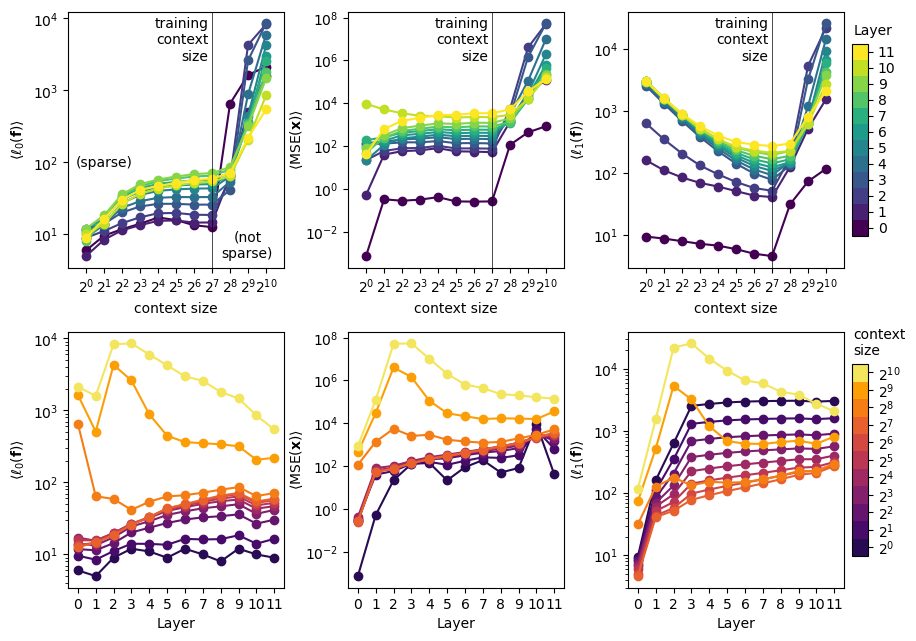

In [19]:
fig = plt.figure(figsize=(8, 8*4/5))
ax1 = fig.add_axes([0,    0.55, 0.27, 0.4])
ax2 = fig.add_axes([0.35, 0.55, 0.27, 0.4])
ax3 = fig.add_axes([0.70, 0.55, 0.27, 0.4])
ax4 = fig.add_axes([0,    0.05, 0.27, 0.4])
ax5 = fig.add_axes([0.35, 0.05, 0.27, 0.4])
ax6 = fig.add_axes([0.70, 0.05, 0.27, 0.4])
cax1 = fig.add_axes([0.98, 0.6, 0.02, 0.3])
cax2 = fig.add_axes([0.98, 0.1, 0.02, 0.3])

norm = matplotlib.colors.Normalize(vmin=0, vmax=11)
sm = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.viridis)
bounds = [i for i in range(13)]
colors = matplotlib.colors.ListedColormap([sm.to_rgba(i) for i in bounds])
norm = matplotlib.colors.BoundaryNorm(bounds, colors.N)
sm = layer_sm = matplotlib.cm.ScalarMappable(norm=norm, cmap=colors)

for i in range(12):
    good = df['layer'] == i
    ax1.plot(np.array(df['context_size'])[good], np.array(df['l0s'])[good], 'o-', c=sm.to_rgba(i))
    ax2.plot(np.array(df['context_size'])[good], np.array(df['mses'])[good], 'o-', c=sm.to_rgba(i))
    ax3.plot(np.array(df['context_size'])[good], np.array(df['l1s'])[good], 'o-', c=sm.to_rgba(i))
# output = ax1.scatter(df['context_size'], df['l0s'], c=df['layer'], cmap=matplotlib.cm.viridis.resampled(12))
# output = ax2.scatter(df['context_size'], df['mses'], c=df['layer'], cmap=matplotlib.cm.viridis.resampled(12))
# output = ax3.scatter(df['context_size'], df['loss_reconst'], c=df['layer'], cmap=matplotlib.cm.viridis.resampled(12))
# ax3.scatter(df['context_size'][::len(context_sizes)], df['loss_base'][::len(context_sizes)], c='k', marker='s', s=100)
cb = plt.colorbar(sm, cax=cax1, norm=norm)
cax1.tick_params(which='minor', color='w')
cb.set_ticks([i+0.5 for i in range(12)])
cb.set_ticklabels([i for i in range(12)])


norm = matplotlib.colors.Normalize(vmin=-2, vmax=12)
sm = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.inferno)
bounds = [i for i in range(0, 12)]
colors = matplotlib.colors.ListedColormap([sm.to_rgba(i) for i in bounds])
norm = matplotlib.colors.BoundaryNorm(bounds, colors.N)
sm = context_sm = matplotlib.cm.ScalarMappable(norm=norm, cmap=colors)

for i, c in enumerate(context_sizes):
    good = df['context_size'] == c
    ax4.plot(np.array(df['layer'][good]), np.array(df['l0s'][good]), 'o-', c=sm.to_rgba(np.log2(c)))
    ax5.plot(np.array(df['layer'][good]), np.array(df['mses'][good]), 'o-', c=sm.to_rgba(np.log2(c)))
    ax6.plot(np.array(df['layer'][good]), np.array(df['l1s'][good]), 'o-', c=sm.to_rgba(np.log2(c)))

# output = ax4.scatter(df['layer'], df['l0s'], c=sm.to_rgba(np.log2(df['context_size'])))#, cmap=matplotlib.cm.inferno.resampled(11))
# ax5.scatter(df['layer'], df['mses'], c=sm.to_rgba(np.log2(df['context_size'])))
# ax6.scatter(df['layer'], df['loss_reconst'], c=sm.to_rgba(np.log2(df['context_size'])))
# ax3.scatter(df['context_size'][::len(context_sizes)], df['loss_base'][::len(context_sizes)], c='k', marker='x', s=50)
cb = plt.colorbar(sm, cax=cax2, norm=norm)

cb.set_ticks([np.log2(c)+0.5 for c in context_sizes])
cb.set_ticklabels([r'$2^{{{}}}$'.format(int(np.log2(c))) for c in context_sizes])

ax1.text(2, 100, '(sparse)', ha='center', va='center')
ax1.text(500, 7, '(not\nsparse)', ha='center', va='center')

for ax in [ax1, ax4]:
    ax.set_ylabel(r'$\langle\ell_0(\mathbf{f})\rangle$')
    ax.set_yscale('log')
for ax in [ax2, ax5]:
    ax.set_ylabel(r'$\langle\rm{MSE}(\mathbf{x})\rangle$', labelpad=0)
    ax.set_yscale('log')
for ax in [ax3, ax6]:
    ax.set_ylabel(r'$\langle\ell_1(\mathbf{f})\rangle$')
    ax.set_yscale('log')
    
for ax in [ax1, ax2, ax3,]:
    ax.set_xlabel('context size')
    ax.set_xscale('log')
    ax.axvline(128, c='k', lw=0.5)
    ax.text(0.65, 0.98, 'training\ncontext\nsize', ha='right', va='top', transform=ax.transAxes)
    ax.set_xticks(context_sizes)
    ax.set_xticklabels([r'$2^{{{}}}$'.format(int(np.log2(c))) for c in context_sizes])
    ax.tick_params(which='minor', color='w')
    ax.set_xlim(0.5, 2048)

for ax in [ax4, ax5, ax6]:
    ax.set_xlabel('Layer')
    ax.set_xticks(range(12))


cax1.text(0.1, 1.03, 'Layer', ha='left', va='bottom', transform=cax1.transAxes)
cax2.text(0.1, 1.03, 'context\nsize', ha='left', va='bottom', transform=cax2.transAxes)



fig.savefig('context_sizes.png', dpi=300, bbox_inches='tight')

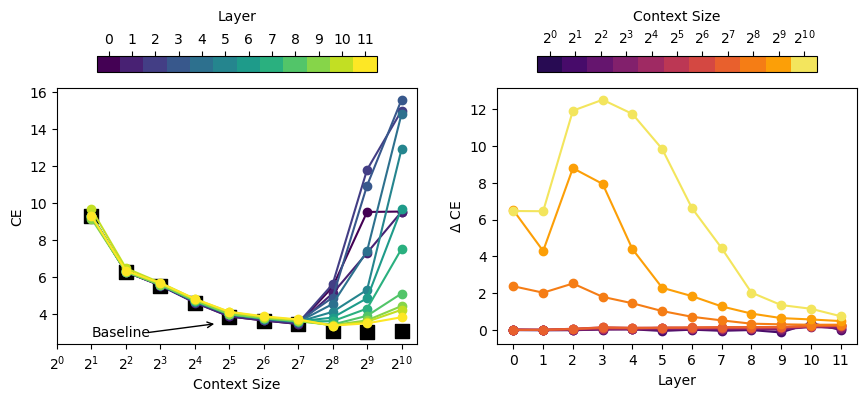

In [20]:
fig = plt.figure(figsize=(8, 16/5))
ax1 = fig.add_axes([0,    0.05,  0.45, 0.8])
ax2 = fig.add_axes([0.55, 0.05,  0.45, 0.8])
cax1 = fig.add_axes([0.05, 0.9, 0.35, 0.05])
cax2 = fig.add_axes([0.60, 0.9, 0.35, 0.05])

for i in range(12):
    good = df['layer'] == i
    ax1.plot(np.array(df['context_size'])[good], np.array(df['loss_reconst'])[good], 'o-', c=layer_sm.to_rgba(i))
    
ax1.scatter(df['context_size'][::len(context_sizes)], df['loss_base'][::len(context_sizes)], c='k', marker='s', s=100)
cb = plt.colorbar(layer_sm, cax=cax1, orientation='horizontal')
cb.set_label('Layer', labelpad=-45)
cax1.tick_params(which='minor', color='w')
cb.set_ticks([i+0.5 for i in range(12)])
cb.set_ticklabels(range(12))
cax1.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax1.set_ylabel('CE')
ax1.set_xlabel('Context Size')
ax1.set_xscale('log')
ax1.set_xticks(context_sizes)
ax1.set_xticklabels([r'$2^{{{}}}$'.format(int(np.log2(c))) for c in context_sizes])
ax1.set_xticklabels([r'$2^{{{}}}$'.format(int(np.log2(c))) for c in context_sizes])
ax1.tick_params(which='minor', color='w')
# ax1.set_xlim(1, 2048)

ax1.text(2, 3, 'Baseline', ha='left', va='center')
ax1.annotate("", xy=(25, 3.5), xytext=(6, 3), arrowprops=dict(arrowstyle="->"))


for i, c in enumerate(context_sizes):
    good = df['context_size'] == c
    ax2.plot(np.array(df['layer'])[good], np.array(df['loss_reconst'][good]) - np.array(df['loss_base'][::len(context_sizes)])[i+1], 'o-', c=sm.to_rgba(np.log2(c)))

ax2.set_xlabel('Layer')
ax2.set_xticks(range(12))
ax2.set_ylabel(r'$\Delta$ CE')

cb = plt.colorbar(context_sm, cax=cax2, orientation='horizontal')

cb.set_ticks([np.log2(c)+0.5 for c in context_sizes])
cb.set_ticklabels([r'$2^{{{}}}$'.format(int(np.log2(c))) for c in context_sizes])
# cb.set_ticklabels(context_sizes)
cax2.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
cax2.set_xlabel('Context Size', labelpad=-45)

fig.savefig('context_sizes_CE.png', dpi=300, bbox_inches='tight')



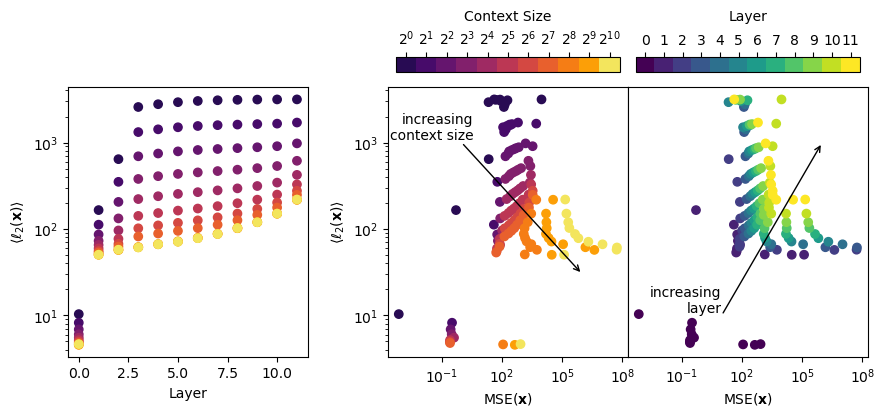

In [41]:
#Also checking what the L2 norm growth looks like as the context length gets longer and showing whether that explains MSE loss.
fig = plt.figure(figsize=(8,3))
ax1 = fig.add_axes([0, 0, 0.3, 0.9])
ax2 = fig.add_axes([0.4, 0, 0.3, 0.9])
ax3 = fig.add_axes([0.7, 0, 0.3, 0.9])
cax1 = fig.add_axes([0.41, 0.95, 0.28, 0.05])
cax2 = fig.add_axes([0.71, 0.95, 0.28, 0.05])
good = df['layer'] >= 0

ax1.scatter(df['layer'], df['act_l2'], c=context_sm.to_rgba(np.log2(df['context_size'][good])))
ax1.set_yscale('log')
ax1.set_ylabel(r'$\langle \ell_2(\mathbf{x}) \rangle$')
ax1.set_xlabel('Layer')


plot = ax2.scatter(np.array(df['mses'])[good], np.array(df['act_l2'])[good], c=context_sm.to_rgba(np.log2(df['context_size'][good])))
cb = plt.colorbar(context_sm, cax=cax1, orientation='horizontal')#, location='top')
cb.set_label('log2(context size)')
# cb.set_ticks([i+0.5 for i in range(11)], labels=[i for i in range(11)])
cb.set_ticks([np.log2(c)+0.5 for c in context_sizes])
cb.set_ticklabels([r'$2^{{{}}}$'.format(int(np.log2(c))) for c in context_sizes])
# cb.set_ticklabels(context_sizes)
cax1.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
cax1.set_xlabel('Context Size', labelpad=-45)

plot = ax3.scatter(np.array(df['mses'][good]), np.array(df['act_l2'][good]), c=layer_sm.to_rgba(df['layer']))#, cmap=layer_sm)
cb = plt.colorbar(layer_sm, cax=cax2, orientation='horizontal')
cb.set_label('Layer', labelpad=-45)
cax2.tick_params(which='minor', color='w')
cb.set_ticks([i+0.5 for i in range(12)])
cb.set_ticklabels(range(12))
cax2.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

ax2.text(4, 1e3, 'increasing\ncontext size', ha='right', va='bottom')
ax2.annotate("", xy=(1e6, 3e1), xytext=(1, 1e3), arrowprops=dict(arrowstyle="->"))

ax3.text(10, 1e1, 'increasing\nlayer', ha='right', va='bottom')
ax3.annotate("", xy=(1e6, 1e3), xytext=(10, 1e1), arrowprops=dict(arrowstyle="->"))

ax2.set_ylabel(r'$\langle \ell_2(\mathbf{x}) \rangle$')
for ax in [ax2, ax3]:
    ax.set_xlabel(r'MSE($\mathbf{x}$)')
    ax.set_xscale('log')
    ax.set_yscale('log')

ax3.tick_params(left=False, which='both', labelleft=False)
fig.savefig('model_activations_vs_mse.png', dpi=300, bbox_inches='tight')

In [14]:
delta_block_mses = 1 - block_mses/np.array(df['mses'][df['context_size'] == 128])[None,:]
delta_block_l0s = 1 - block_l0s/np.array(df['l0s'][df['context_size'] == 128])[None,:]
delta_block_act_l2s = 1 - block_act_l2s/np.array(df['act_l2'][df['context_size'] == 128])[None,:]
delta_block_mses[block_mses == 0] = 0
delta_block_l0s[block_l0s == 0] = 0
delta_block_act_l2s[block_act_l2s == 0] = 0

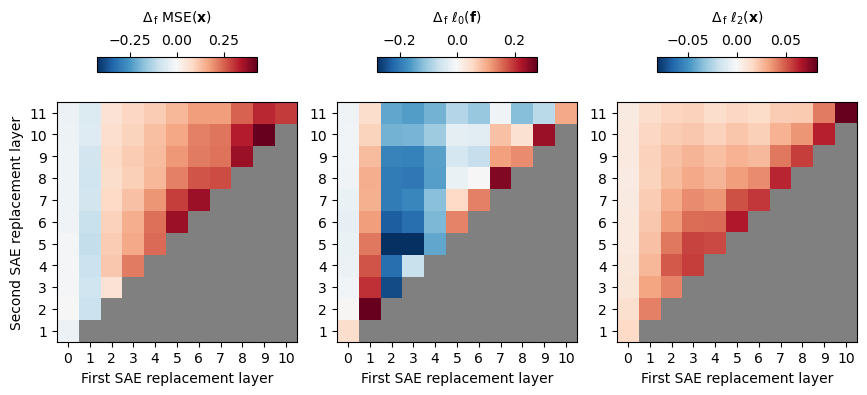

In [15]:
fig = plt.figure(figsize=(8,3))
ax1 = fig.add_axes((0.00, 0.00, 0.3, 0.9))
ax2 = fig.add_axes((0.35, 0.00, 0.3, 0.9))
ax3 = fig.add_axes((0.70, 0.00, 0.3, 0.9))

cax1 = fig.add_axes((0.05, 0.95, 0.2, 0.05))
cax2 = fig.add_axes((0.40, 0.95, 0.2, 0.05))
cax3 = fig.add_axes((0.75, 0.95, 0.2, 0.05))

axs = [ax1, ax2, ax3]
caxs = [cax1, cax2, cax3]
cbs = []

yy, xx = np.meshgrid(np.arange(12), np.arange(12))
# print(delta_block_mses.shape)
for ax, cax, mat in zip(axs, caxs, (delta_block_mses, delta_block_l0s, delta_block_act_l2s)):
    ax.set_facecolor("grey")
    masked = np.ma.masked_where(yy <= xx, mat.mean(axis=0))
    # print(masked)
    m = ax.imshow(masked.T, vmin=-np.max(masked), vmax=np.max(masked), cmap='RdBu_r')
    cbs.append(plt.colorbar(m, cax=cax, orientation='horizontal'))
    ax.set_xlabel('First SAE replacement layer')
    ax.set_xticks([i for i in range(11)])
    ax.set_xticklabels(range(11))
    ax.set_yticks([i for i in range(1,12)])
    ax.set_yticklabels(range(1,12))
    ax.set_ylim(0.5, 11.5)
    ax.set_xlim(-0.5, 10.5)
    cax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
axs[0].set_ylabel('Second SAE replacement layer')
cbs[0].set_label(r'$\Delta_{\,\rm f}$ MSE($\mathbf{x}$)', labelpad=-45)
cbs[1].set_label(r'$\Delta_{\,\rm f}$ $\ell_0(\mathbf{f})$', labelpad=-45)
cbs[2].set_label(r'$\Delta_{\,\rm f}$ $\ell_2(\mathbf{x})$', labelpad=-45)
fig.savefig('err_prop.png', dpi=300, bbox_inches='tight')

# Children's Book Test

Original paper: https://arxiv.org/pdf/1511.02301.pdf


GPT2 paper context:

"Following the LM approach introduced in the original paper, we compute *the
probability of each choice and the rest of the sentence conditioned on this choice according to the LM, and predict
the one with the highest probability.* ... Data overlap analysis showed one of the CBT
test set books, The Jungle Book by Rudyard Kipling, is in
WebText, so we report results on the validation set which
has no significant overlap. ... A de-tokenizer was applied to remove PTB style
tokenization artifacts from CBT."

We'll just get logit distribution on the 'fill-in' token prediction, show probability ratio of the correct answer in that set vs median prob

In [9]:
cbt = datasets.load_dataset("cbt", 'CN', split='validation')

In [10]:
sentences = cbt['sentences']
question = cbt['question']
answer = cbt['answer']
options = cbt['options']

In [11]:
cbt_prompts = [''.join([s+' ' for s in text] + [question.split('XXXXX')[0][:-1]]) for text,question in zip(sentences,question)]
cbt_answers = [tokenizer.encode(' '+ text)[0] for text in answer]
cbt_choices = [t.Tensor([tokenizer.encode(' ' + option)[0] for option in opts]).to(int) for opts in options]
cbt_points = 1000
batch_size = 2

In [12]:
model.reset_hooks()
gc.collect()
t.cuda.empty_cache()
cbt_baseline = test_next_token(cbt_prompts, cbt_answers, comparison_tokens = cbt_choices,
                    model_call=model.run_with_cache, tot=cbt_points, batch_size=batch_size)

  0%|          | 0/500 [00:00<?, ?it/s]

acc: 41.90%


In [13]:
cbt_residual_logs = []
model.reset_hooks()
for i, sparse_autoencoder in enumerate(sparse_encoders_residual):
    def residual_replacement_hook(activations, hook):
        sae_out = sparse_autoencoder.forward(activations)[0].to(activations.dtype)
        activations[:] = sae_out

    act_name = sparse_autoencoder.cfg.hook_point

    model.add_hook(act_name, residual_replacement_hook)
    model_runner = model.run_with_cache

    print(f'running encoder on activation { act_name } ')
    this_log = test_next_token(cbt_prompts, cbt_answers, comparison_tokens = cbt_choices,
                                sparse_encoder = sparse_autoencoder, act_name=act_name,
                                model_call=model_runner, tot=cbt_points, batch_size=batch_size)
    this_log['feat_activations'] = (this_log['feat_activations'] > 0).sum(axis=1)
    cbt_residual_logs.append(this_log)

    model.reset_hooks()

running encoder on activation blocks.0.hook_resid_pre 


  0%|          | 0/500 [00:00<?, ?it/s]

acc: 0.10%
running encoder on activation blocks.1.hook_resid_pre 


  0%|          | 0/500 [00:00<?, ?it/s]

acc: 0.40%
running encoder on activation blocks.2.hook_resid_pre 


  0%|          | 0/500 [00:00<?, ?it/s]

acc: 0.00%
running encoder on activation blocks.3.hook_resid_pre 


  0%|          | 0/500 [00:00<?, ?it/s]

acc: 0.20%
running encoder on activation blocks.4.hook_resid_pre 


  0%|          | 0/500 [00:00<?, ?it/s]

acc: 0.20%
running encoder on activation blocks.5.hook_resid_pre 


  0%|          | 0/500 [00:00<?, ?it/s]

acc: 2.60%
running encoder on activation blocks.6.hook_resid_pre 


  0%|          | 0/500 [00:00<?, ?it/s]

acc: 4.80%
running encoder on activation blocks.7.hook_resid_pre 


  0%|          | 0/500 [00:00<?, ?it/s]

acc: 10.90%
running encoder on activation blocks.8.hook_resid_pre 


  0%|          | 0/500 [00:00<?, ?it/s]

acc: 18.40%
running encoder on activation blocks.9.hook_resid_pre 


  0%|          | 0/500 [00:00<?, ?it/s]

acc: 21.60%
running encoder on activation blocks.10.hook_resid_pre 


  0%|          | 0/500 [00:00<?, ?it/s]

acc: 24.30%
running encoder on activation blocks.11.hook_resid_pre 


  0%|          | 0/500 [00:00<?, ?it/s]

acc: 27.60%


In [14]:
if DO_ATTN_SAE:
    cbt_attn_logs = []
    model.reset_hooks()
    for i, sparse_autoencoder in enumerate(sparse_encoders_attn):
        act_name = sparse_autoencoder.cfg['act_name']
        def attn_replacement_hook(activations, hook):
            if sparse_autoencoder.cfg["concat_heads"]:
                acts = einops.rearrange(
                    activations, "batch seq n_heads d_head -> batch seq (n_heads d_head)",
                )
            sae_out = sparse_autoencoder.forward(acts)[1].to(activations.dtype)
            if sparse_autoencoder.cfg["concat_heads"]:
                activations[:] = einops.rearrange(
                        sae_out, "batch seq (n_heads d_head) -> batch seq n_heads d_head",
                        n_heads = activations.shape[2]
                    )
            else:
                activations[:] = sae_out

        model.add_hook(act_name, attn_replacement_hook)
        model_runner = model.run_with_cache

        print(f'running encoder on activation { act_name } ')
        this_log = test_next_token(cbt_prompts, cbt_answers, comparison_tokens = cbt_choices,
                                    sparse_encoder = sparse_autoencoder, act_name=act_name,
                                    model_call=model_runner, tot=cbt_points, batch_size=batch_size)
        cbt_attn_logs.append(this_log)

        model.reset_hooks()

In [15]:
#look at the mean and stdev delta probability of the correct answer for each SAE
baseline_ln_probs = cbt_baseline['logit_answer'] - cbt_baseline['logit_norm']

df = pandas.DataFrame()

name = []
delta_ln = []
l0 = []
l1 = []
mse = []
l2_activation = []
layers = []
df_answers = model.to_str_tokens([model.to_string(cbt_answers[i]) for i in range(cbt_points)], prepend_bos=False)*(24 if DO_ATTN_SAE else 12)
for i, log in enumerate(cbt_residual_logs):
    ln_probs = log['logit_answer'] - log['logit_norm']
    delta_ln_probs = (ln_probs - baseline_ln_probs)
    log['delta_ln_probs'] = delta_ln_probs
    delta_ln += list(delta_ln_probs)
    l0 += list(log['sae_l0'])
    l1 += list(log['sae_l1'])
    mse += list(log['sae_mse'])
    l2_activation += list(log['activation_l2'])
    name += [f'{sparse_encoders_residual[i].cfg.hook_point}'] * len(delta_ln_probs)
    layers += [int(sparse_encoders_residual[i].cfg.hook_point.split('.hook')[0].split('blocks.')[-1])]*len(delta_ln_probs)

if DO_ATTN_SAE:
    for i, log in enumerate(cbt_attn_logs):
        ln_probs = log['logit_answer'] - log['logit_norm']
        delta_ln_probs = (ln_probs - baseline_ln_probs)
        log['delta_ln_probs'] = delta_ln_probs
        delta_ln += list(delta_ln_probs)
        l0 += list(log['sae_l0'])
        l1 += list(log['sae_l1'])
        mse += list(log['sae_mse'])
        l2_activation += list(log['activation_l2'])
        act_name = sparse_encoders_attn[i].cfg['act_name']
        name += [f'{act_name}'] * len(delta_ln_probs)

df['delta_ln_prob'] = delta_ln
df['name'] = name
df['answers'] = df_answers
df['l0'] = l0
df['l1'] = l1
df['l2_activation'] = l2_activation
df['mse'] = mse
df['layer'] = layers




In [171]:
#feat_activations is [n_samples, n_features].
# feat_activations > 0 says when it's active.
# delta_ln_prob is [n_samples]
# for each feature (feat_activations[:,:,i] > 0) gives a mask for delta_ln_prob that lets me get a mean and stdev.
for i, log in enumerate(cbt_residual_logs):
    mask = log['feat_activations'] > 0
    feat_means = 100*np.ones(mask.shape[1])
    feat_stds = 100*np.ones_like(feat_means)
    feat_good = np.zeros_like(feat_means)
    for j in range(feat_means.shape[0]):
        if mask[:,j].sum() > 0:
            feat_means[j] = log['delta_ln_probs'][mask[:,j]].mean()
            feat_stds[j]  = log['delta_ln_probs'][mask[:,j]].std()
            goodness = (log['delta_ln_probs'][mask[:,j]] >= 0).astype(int)
            goodness[goodness == 0] = -1
            feat_good[j] = np.sum(goodness)
            
    log['feat_means'] = feat_means
    log['feat_stds'] = feat_stds
    log['feat_good'] = feat_good

In [172]:
#safe df to file for plotting offline if we want to do that sans-gpu
df.to_csv("cbt_df.csv")
for i, log in enumerate(cbt_residual_logs):
    with open(f'cbt_residual_log_{i}.pkl', 'wb') as handle:
        pickle.dump(log, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('cbt_baseline_log.pkl', 'wb') as handle:
    pickle.dump(cbt_baseline, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [173]:
df = pandas.read_csv('cbt_df.csv')
cbt_residual_logs = []
for i in range(len(sparse_encoders_residual)):
     with open(f'cbt_residual_log_{i}.pkl', 'rb') as handle:
         log = pickle.load(handle)
         cbt_residual_logs.append(log)
with open('cbt_baseline_log.pkl', 'rb') as handle:
    cbt_baseline = pickle.load(handle)

In [174]:
def plot_histograms(logs, dataset):
    fig = plt.figure(figsize=(8,6))
    ax1 = fig.add_axes((0, 0.55, 0.95, 0.45))
    ax2 = fig.add_axes((0, 0.00, 0.95, 0.45))
    cax = fig.add_axes((0.97, 0.1, 0.03, 0.8))
    for i,log in enumerate(logs):
        ax1.hist(log['feat_means'][log['feat_means'] != 100], bins=100, color=layer_sm.to_rgba(i), alpha=0.6)
        ax2.hist(log['feat_good'], bins=100, color=layer_sm.to_rgba(i), alpha=0.6)
    
    for ax in [ax1, ax2]:
        ax.set_yscale('log')
        ax.set_ylabel('Features')
        ax.axvline(0, c='k')
    ax1.set_xlabel(r'Mean $\Delta \ln p$ when feature is active')
    ax1.set_xlim(-18, 4)
    ax1.text(0.825, 0.93, 'Improves model', ha='left', transform=ax1.transAxes)
    ax1.text(0.8, 0.93, 'Degrades model', ha='right', transform=ax1.transAxes)
    ax2.set_xlabel(r'Feature score')
    cax.text(0.5, 1.05, 'Layer', ha='center', va='center', transform=cax.transAxes)
    cbar = plt.colorbar(layer_sm, cax=cax)
    cbar.set_ticks([i+0.5 for i in range(12)])
    cbar.set_ticklabels(range(12))
    fig.savefig('feature_hist_{}.png'.format(dataset), dpi=300, bbox_inches='tight')

In [175]:

def activation_scatterplots(df, dataset, xscale='log'):
    fig = plt.figure(figsize=(8, 8))
    ax1 = fig.add_axes([0,    0.55, 0.42, 0.4])
    ax2 = fig.add_axes([0.50, 0.55, 0.42, 0.4])
    ax3 = fig.add_axes([0,    0.05, 0.42, 0.4])
    ax4 = fig.add_axes([0.50, 0.05, 0.42, 0.4])
    cax = fig.add_axes([0.95, 0.10, 0.05, 0.8])
    
    #create an array of activations normalized by minimum activation in each layer.
    acts = np.copy(df['l2_activation'])
    for i in range(12):
        mask = df['layer'] == i
        acts[mask] /= acts[mask].min()
    
    for ax in [ax1, ax2, ax3, ax4]:
        ax.set_xlabel(r'Normalized $\ell_2(\mathbf{x})$')
        ax.set_yscale('log')
        if xscale == 'log':
            ax.set_xscale('log')
    ax4.set_yscale('linear')
    ax4.axhline(0, c='k', lw=0.5)
    
    scatter_kwargs = dict(s=10, alpha=0.5, linewidth=0, c=layer_sm.to_rgba(df['layer']))
    
    ax1.scatter(acts, df['mse'], **scatter_kwargs)
    ax2.scatter(acts, df['l0'], **scatter_kwargs)
    ax3.scatter(acts, df['l1'], **scatter_kwargs)
    ax4.scatter(acts, df['delta_ln_prob'], **scatter_kwargs)
    cbar = plt.colorbar(layer_sm, cax=cax)
    cbar.set_ticks([i+0.5 for i in range(12)])
    cbar.set_ticklabels(range(12))
    
    ax1.set_ylabel(r'MSE($\mathbf{x}$)')
    ax2.set_ylabel(r'$\ell_0(\mathbf{f})$')
    ax3.set_ylabel(r'$\ell_1(\mathbf{f})$')
    ax4.set_ylabel(r'$\Delta \ln p$')

    
    cax.text(0.5, 1.01, 'Layer', ha='center', va='bottom', transform=cax.transAxes)
    
    fig.savefig('activation_scatterplot_{}.png'.format(dataset), dpi=300, bbox_inches='tight')

In [176]:
def layer_effect_plot(quantity, df, points, dataset, yscale='linear', ylim=None):
    fig = plt.figure(figsize=(8,4))
    ax1 = fig.add_axes([0.00, 0.05, 0.43, 0.9])
    ax2 = fig.add_axes([0.52, 0.05, 0.43, 0.9])
    cax = fig.add_axes([0.97, 0.15, 0.03, 0.7])

    if quantity == 'delta_ln_prob':
        label = r'$\Delta \ln p$'
    elif quantity == 'l2_activation':
        label = r'$\ell_2(\mathbf{x})$'

    
    for ax in [ax1, ax2]:
        ax.set_yscale(yscale)
        if ylim is not None:
            ax.set_ylim(*ylim)
    
    
    parts = ax1.violinplot([df[quantity][df['layer'] == i] for i in range(12)], positions=np.arange(12))#, showmeans=True)
    for partname in ('cbars','cmins','cmaxes'):#'cmeans','cmedians'):
        pc = parts[partname]
        # print(dir(pc))
        pc.set_color('k')
        pc.set_linewidth(1)
        pc.set_alpha(1)
    for pc in parts['bodies']:
        pc.set_alpha(0)
    
        
    ax1.scatter(df['layer'] + (np.random.rand(df['layer'].shape[0])-0.5)*0.3, df[quantity], s=1, alpha=0.75, c='orange')
    ax1.set_xlabel('Layer')
    ax1.set_ylabel(label)
    
    
    for i in range(12):
        ax1.scatter(i, np.percentile(df[quantity][df['layer'] == i], 50), marker='_', c='k', s=100)
    
    
    # for each data point, get [layer, delta ln p]
    x = [i for i in range(12)]
    y = [np.array(df[quantity][i::points]) for i in range(points)]

    if yscale == 'linear':
        mean = df[quantity][df['layer'] == 0].mean()
        std = df[quantity][df['layer'] == 0].std() 
    elif yscale == 'log':
        mean = np.log10(df[quantity][df['layer'] == 0]).mean()
        std  = np.log10(df[quantity][df['layer'] == 0]).std() 
    norm = matplotlib.colors.Normalize(vmin=mean-2*std, vmax=mean+2*std)
    sm = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.magma_r)
    
    for i in range(len(y)):
        if yscale == 'log':
            cy = np.log10(y[i][0])
        else:
            cy = y[i][0]
        ax2.plot(x, y[i], color=sm.to_rgba(cy), alpha=0.7);
    plt.colorbar(sm, cax=cax)
    ax2.set_xlabel('Layer')

    if yscale == 'log':
        tag = 'log10\n'
    else:
        tag = ''
    cax.text(0.01, 1.01, tag+'Layer 0\n'+label, ha='left', va='bottom', transform=cax.transAxes);
    
    fig.savefig('layer_effect_{}_{}.png'.format(quantity, dataset), dpi=300, bbox_inches='tight')

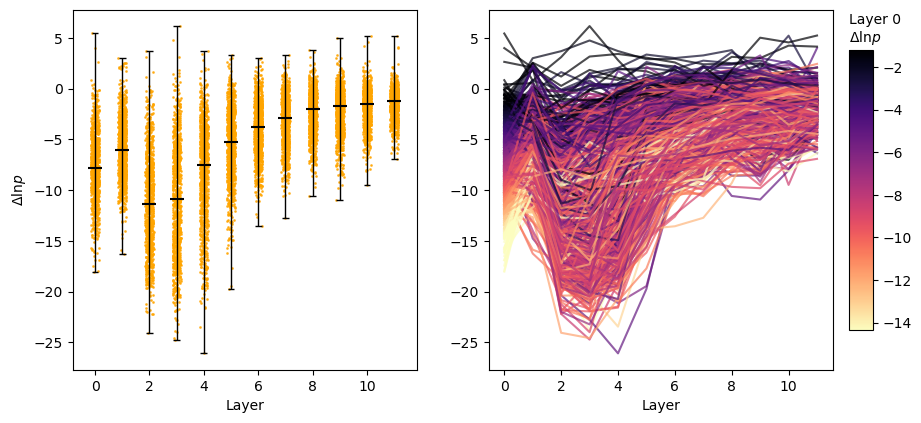

In [177]:
layer_effect_plot('delta_ln_prob', df, cbt_points, 'cbt', yscale='linear', ylim=None)

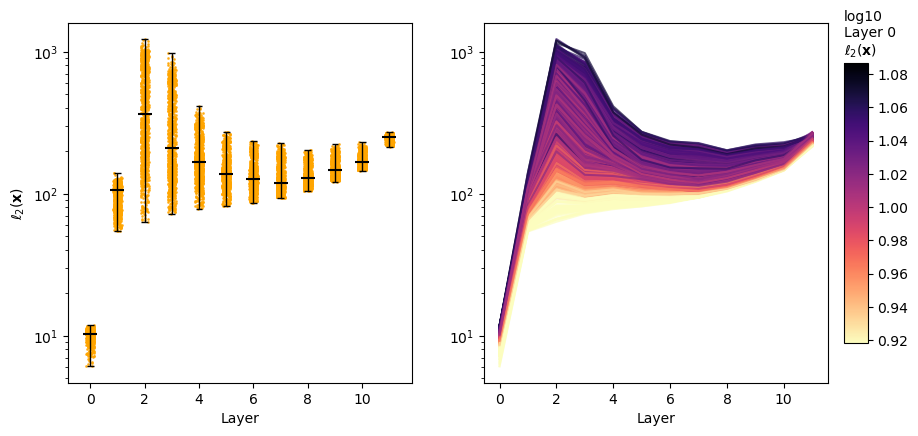

In [178]:
layer_effect_plot('l2_activation', df, lambada_points, 'cbt', yscale='log', ylim=None)

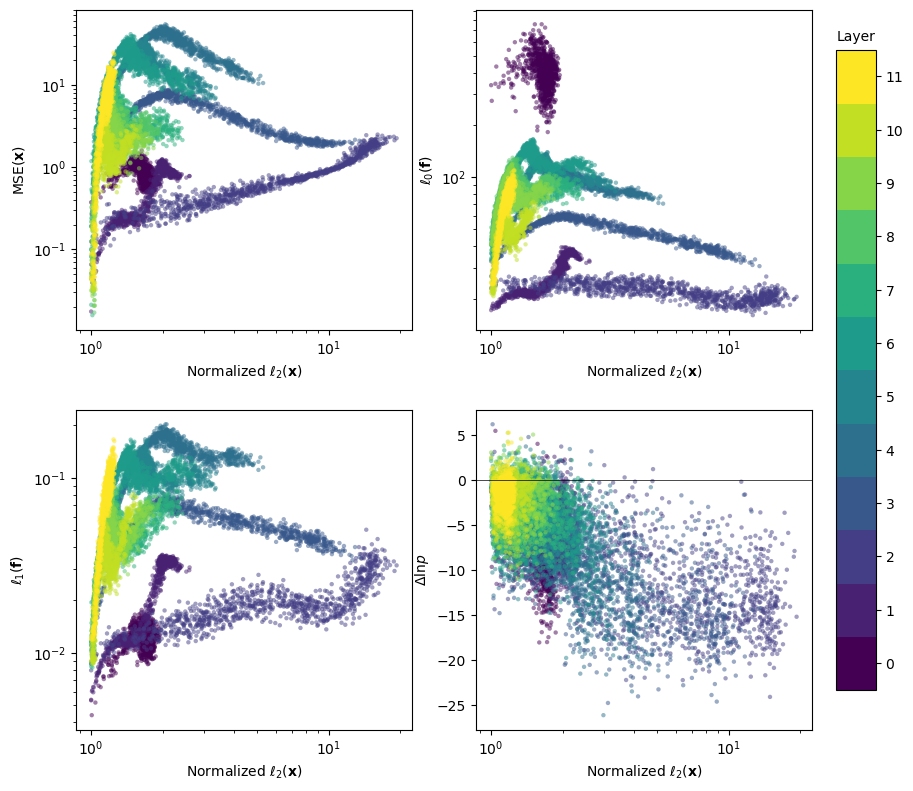

In [179]:
activation_scatterplots(df, 'cbt')

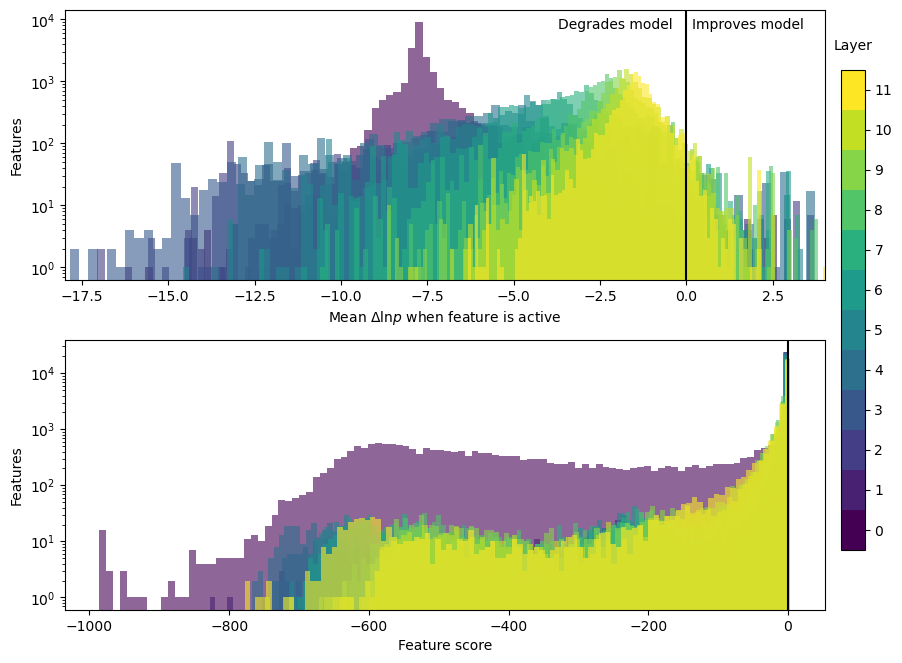

In [180]:
plot_histograms(cbt_residual_logs, 'cbt')

# Lambada

In [57]:
lambada = datasets.load_dataset("lambada")

Generating train split:   0%|          | 0/2662 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5153 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4869 [00:00<?, ? examples/s]

In [58]:
lambada_prompts = [text.rsplit(' ', 1)[0] for text in lambada['test']['text']]
lambada_answers = [tokenizer.encode(' ' + text.rsplit(' ', 1)[1])[0] for text in lambada['test']['text']]
lambada_points = 1000
lambada_batch_size = 20

In [59]:
max_len = len(lambada_prompts)
model.reset_hooks()
lambada_baseline = test_next_token(lambada_prompts, lambada_answers, model_call=model.run_with_cache, tot=lambada_points, batch_size=lambada_batch_size) #27.07% accuracy on 5150 prompts

  0%|          | 0/50 [00:00<?, ?it/s]

acc: 26.60%


In [60]:
t.cuda.empty_cache()
gc.collect()
lambada_residual_logs = []
model.reset_hooks()
for i, sparse_autoencoder in enumerate(sparse_encoders_residual):

    def residual_replacement_hook(activations, hook):
        sae_out = sparse_autoencoder.forward(activations)[0].to(activations.dtype)
        activations[:] = sae_out

    act_name = sparse_autoencoder.cfg.hook_point

    model.add_hook(act_name, residual_replacement_hook)
    model_runner = model.run_with_cache

    print(f'running encoder on activation { act_name } ')
    this_log = test_next_token(lambada_prompts, lambada_answers,
                                sparse_encoder = sparse_autoencoder, act_name=act_name,
                                model_call=model_runner, tot=lambada_points, batch_size=lambada_batch_size,
                                activations_length=32)
    this_log['feat_activations'] = (this_log['feat_activations'] > 0).sum(axis=1)
    lambada_residual_logs.append(this_log)

    model.reset_hooks()

running encoder on activation blocks.0.hook_resid_pre 


  0%|          | 0/50 [00:00<?, ?it/s]

acc: 25.60%
running encoder on activation blocks.1.hook_resid_pre 


  0%|          | 0/50 [00:00<?, ?it/s]

acc: 24.80%
running encoder on activation blocks.2.hook_resid_pre 


  0%|          | 0/50 [00:00<?, ?it/s]

acc: 22.40%
running encoder on activation blocks.3.hook_resid_pre 


  0%|          | 0/50 [00:00<?, ?it/s]

acc: 21.10%
running encoder on activation blocks.4.hook_resid_pre 


  0%|          | 0/50 [00:00<?, ?it/s]

acc: 20.30%
running encoder on activation blocks.5.hook_resid_pre 


  0%|          | 0/50 [00:00<?, ?it/s]

acc: 17.20%
running encoder on activation blocks.6.hook_resid_pre 


  0%|          | 0/50 [00:00<?, ?it/s]

acc: 17.80%
running encoder on activation blocks.7.hook_resid_pre 


  0%|          | 0/50 [00:00<?, ?it/s]

acc: 18.20%
running encoder on activation blocks.8.hook_resid_pre 


  0%|          | 0/50 [00:00<?, ?it/s]

acc: 16.90%
running encoder on activation blocks.9.hook_resid_pre 


  0%|          | 0/50 [00:00<?, ?it/s]

acc: 14.80%
running encoder on activation blocks.10.hook_resid_pre 


  0%|          | 0/50 [00:00<?, ?it/s]

acc: 13.20%
running encoder on activation blocks.11.hook_resid_pre 


  0%|          | 0/50 [00:00<?, ?it/s]

acc: 10.60%


In [61]:
if DO_ATTN_SAE:
    lambada_attn_logs = []
    model.reset_hooks()
    for i, sparse_autoencoder in enumerate(sparse_encoders_attn):
    
        def attn_replacement_hook(activations, hook):
            if sparse_autoencoder.cfg["concat_heads"]:
                acts = einops.rearrange(
                    activations, "batch seq n_heads d_head -> batch seq (n_heads d_head)",
                )
            sae_out = sparse_autoencoder.forward(acts)[1].to(activations.dtype)
            if sparse_autoencoder.cfg["concat_heads"]:
                activations[:] = einops.rearrange(
                        sae_out, "batch seq (n_heads d_head) -> batch seq n_heads d_head",
                        n_heads = activations.shape[2]
                    )
            else:
                activations[:] = sae_out
    
        act_name = sparse_autoencoder.cfg['act_name']
    
        model.add_hook(act_name, attn_replacement_hook)
        model_runner = model.run_with_cache
    
        print(f'running encoder on activation { act_name } ')
        this_log = test_next_token(lambada_prompts, lambada_answers,
                                    sparse_encoder = sparse_autoencoder, act_name=act_name,
                                    model_call=model_runner, tot=lambada_points, batch_size=lambada_batch_size,
                                  activations_length=32)
        this_log['feat_activations'] = (this_log['feat_activations'] > 0).sum(axis=1)
        lambada_attn_logs.append(this_log)
    
        model.reset_hooks()

In [62]:
#look at the mean and stdev delta probability of the correct answer for each SAE
baseline_ln_probs = lambada_baseline['logit_answer'] - lambada_baseline['logit_norm']

df = pandas.DataFrame()

name = []
delta_ln = []
l0 = []
l1 = []
mse = []
l2_activation = []
layers = []
df_answers = model.to_str_tokens([model.to_string(lambada_answers[i]) for i in range(lambada_points)], prepend_bos=False)*(24 if DO_ATTN_SAE else 12)
for i, log in enumerate(lambada_residual_logs):
    ln_probs = log['logit_answer'] - log['logit_norm']
    delta_ln_probs = (ln_probs - baseline_ln_probs)
    log['delta_ln_probs'] = delta_ln_probs
    delta_ln += list(delta_ln_probs)
    l0 += list(log['sae_l0'])
    l1 += list(log['sae_l1'])
    mse += list(log['sae_mse'])
    l2_activation += list(log['activation_l2'])
    name += [f'{sparse_encoders_residual[i].cfg.hook_point}'] * len(delta_ln_probs)
    layers += [int(sparse_encoders_residual[i].cfg.hook_point.split('.hook')[0].split('blocks.')[-1])]*len(delta_ln_probs)

if DO_ATTN_SAE:
    for i, log in enumerate(lambada_attn_logs):
        ln_probs = log['logit_answer'] - log['logit_norm']
        delta_ln_probs = (ln_probs - baseline_ln_probs)
        log['delta_ln_probs'] = delta_ln_probs
        delta_ln += list(delta_ln_probs)
        l0 += list(log['sae_l0'])
        l1 += list(log['sae_l1'])
        mse += list(log['sae_mse'])
        l2_activation += list(log['activation_l2'])
        act_name = sparse_encoders_attn[i].cfg['act_name']
        name += [f'{act_name}'] * len(delta_ln_probs)

df['delta_ln_prob'] = delta_ln
df['name'] = name
df['answers'] = df_answers
df['l0'] = l0
df['l1'] = l1
df['l2_activation'] = l2_activation
df['mse'] = mse
df['layer'] = layers




In [165]:
#feat_activations is [n_samples, n_features].
# feat_activations > 0 says when it's active.
# delta_ln_prob is [n_samples]
# for each feature (feat_activations[:,:,i] > 0) gives a mask for delta_ln_prob that lets me get a mean and stdev.
for i, log in enumerate(lambada_residual_logs):
    mask = log['feat_activations'] > 0
    feat_means = 100*np.ones(mask.shape[1])
    feat_stds = 100*np.ones_like(feat_means)
    feat_good = np.zeros_like(feat_means)
    for j in range(feat_means.shape[0]):
        if mask[:,j].sum() > 0:
            feat_means[j] = log['delta_ln_probs'][mask[:,j]].mean()
            feat_stds[j]  = log['delta_ln_probs'][mask[:,j]].std()
            goodness = (log['delta_ln_probs'][mask[:,j]] >= 0).astype(int)
            goodness[goodness == 0] = -1
            feat_good[j] = np.sum(goodness)
            
    log['feat_means'] = feat_means
    log['feat_stds'] = feat_stds
    log['feat_good'] = feat_good

In [166]:
#safe df to file for plotting offline if we want to do that sans-gpu
df.to_csv("lambada_df.csv")
for i, log in enumerate(lambada_residual_logs):
    with open(f'lambada_residual_log_{i}.pkl', 'wb') as handle:
        pickle.dump(log, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('lambada_baseline_log.pkl', 'wb') as handle:
    pickle.dump(lambada_baseline, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [164]:
df = pandas.read_csv('lambada_df.csv')
lambada_residual_logs = []
for i in range(len(sparse_encoders_residual)):
     with open(f'lambada_residual_log_{i}.pkl', 'rb') as handle:
         log = pickle.load(handle)
         lambada_residual_logs.append(log)
with open('lambada_baseline_log.pkl', 'rb') as handle:
    lambada_baseline = pickle.load(handle)

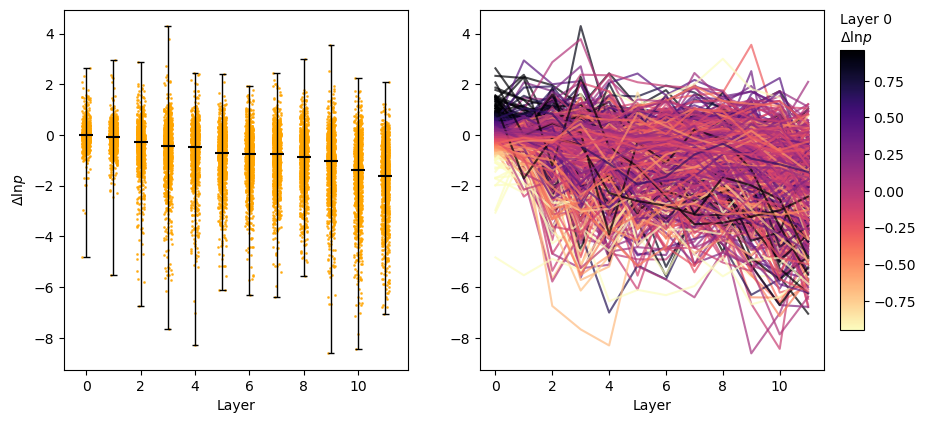

In [168]:
layer_effect_plot('delta_ln_prob', df, lambada_points, 'lambada')

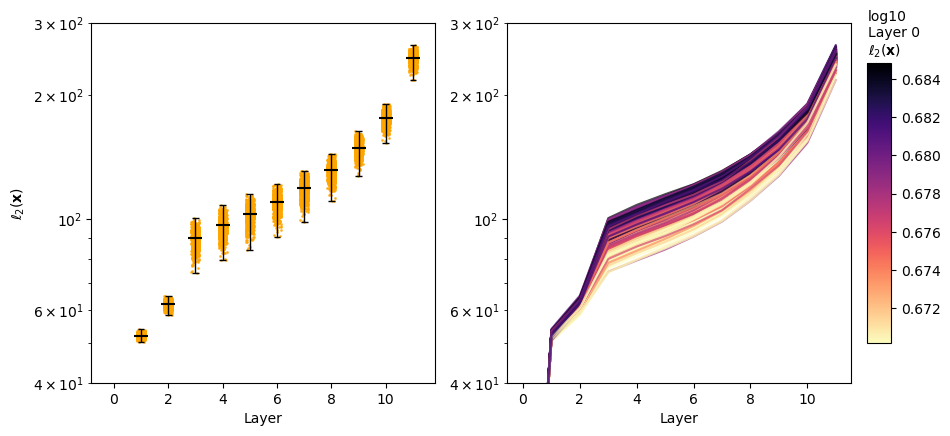

In [169]:
layer_effect_plot('l2_activation', df, lambada_points, 'lambada', yscale='log', ylim=(4e1, 3e2))

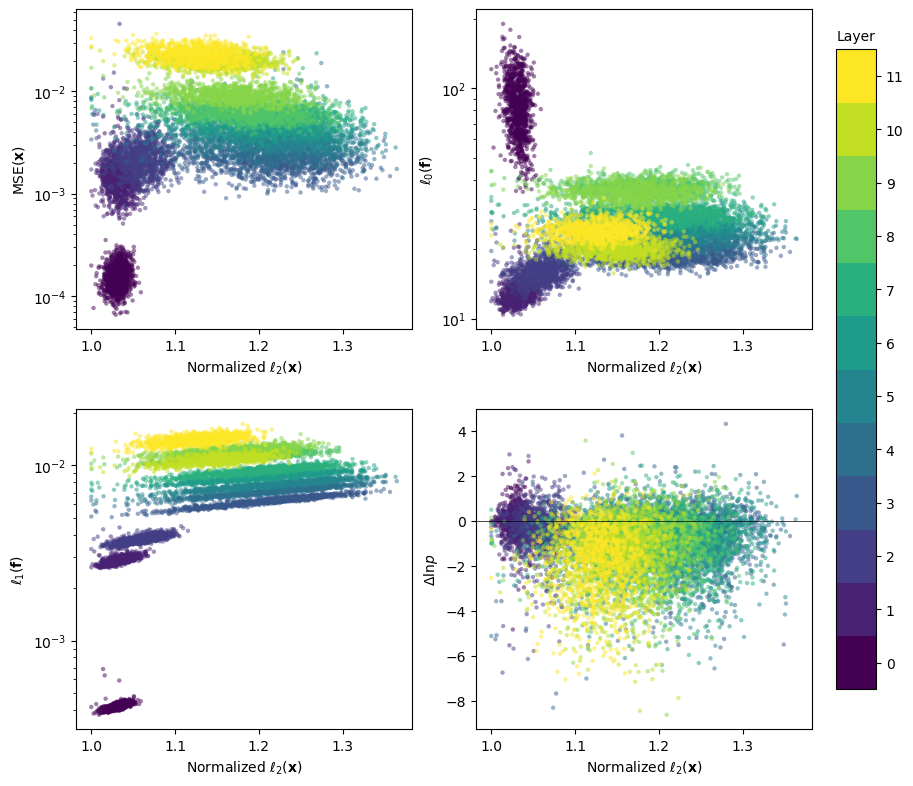

In [144]:
activation_scatterplots(df, 'lambada', xscale='linear')

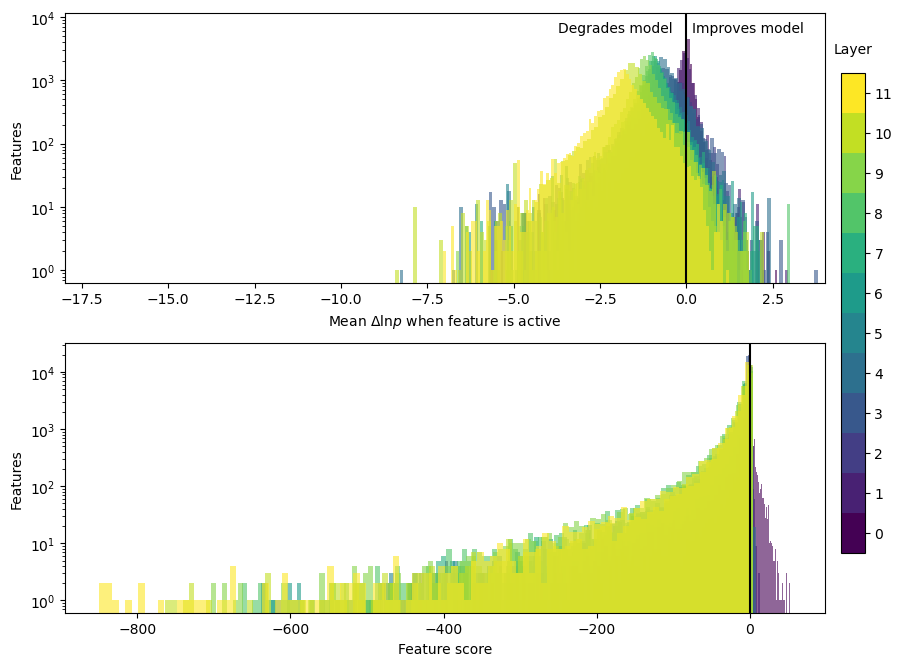

In [167]:
plot_histograms(lambada_residual_logs, 'lambada')